Import the necessary libraries.

In [1]:
import csv
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
from create_input_lists import create_input_lists_from_csv, lemmatize
from statistics import mean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from statistics import mean, median, mode
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict, Counter

Obtain and pre-process the texts.

In [2]:
paragraph_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/paragraphs.csv'
assessment_path = './OneDrive-2020-12-04/intro_bio (with periods)_labelled/assessments.csv'

In [3]:
para_ids, lemm_para, orig_para, assess_ids, lemma_assess, orig_assess = create_input_lists_from_csv(paragraph_path, assessment_path)

Obtain the BERT embeddings of the texts.

In [4]:
def get_embeddings_sentBert(texts):
    model = SentenceTransformer('paraphrase-distilroberta-base-v2')
    text_embeddings = model.encode(texts)

    return np.array(text_embeddings)

para_vectors = get_embeddings_sentBert(lemm_para)
assess_vectors = get_embeddings_sentBert(lemma_assess)

In [5]:
print(para_vectors.shape)
print(assess_vectors.shape)

(1608, 768)
(1095, 768)


In [6]:
para_nonzero_counts = []
for vector in para_vectors:
    para_nonzero_counts.append(np.count_nonzero(vector))

assess_nonzero_counts = []
for vector in assess_vectors:
    assess_nonzero_counts.append(np.count_nonzero(vector))

Output Summary Statistics of Vectorizations:

In [7]:
print('TF-IDF for Paragraphs:\n')
print('Average Number of Non-Zeros:', mean(para_nonzero_counts))
print('Total # of Dimensions:', para_vectors.shape[1])


print('\n\nTF-IDF for Assessments:\n')
print('Average Number of Non-Zeros:', mean(assess_nonzero_counts))
print('Total # of Dimensions:', assess_vectors.shape[1])

TF-IDF for Paragraphs:

Average Number of Non-Zeros: 768
Total # of Dimensions: 768


TF-IDF for Assessments:

Average Number of Non-Zeros: 768
Total # of Dimensions: 768


In [8]:
def plot_distances(distances_list):
    plt.hist(distances_list, rwidth = 0.8, bins=np.arange(min(distances_list), max(distances_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Distance',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(distances_list), max(distances_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def plot_similarities(cos_sim_list):
    plt.hist(cos_sim_list, rwidth = 0.8, bins=np.arange(min(cos_sim_list), max(cos_sim_list) + 0.01, 0.01))
    plt.xlabel('Pairwise Cosine Similarity',fontsize=10)
    plt.ylabel('Frequency',fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.xticks(np.arange(min(cos_sim_list), max(cos_sim_list)+0.1, 0.1))
    plt.grid()
    plt.show()
    
def calculate_pairwise_metrics(pairs):    
    cos_sim_list = []
    dist_list = []
    orthogonal_count = 0
    for pair in pairs:
        a,b = pair
        a = np.array(a)
        b = np.array(b)
        cos_sim = dot(a, b)/(norm(a)*norm(b))
        cos_sim_list.append(cos_sim)

        if -0.01 <= cos_sim <= 0.01:
            orthogonal_count += 1

        dist = norm(a - b)
        dist_list.append(dist)
    
    return(cos_sim_list, orthogonal_count, dist_list)

def print_similarity_statistics(sim_list):
    print('Cosine Similarity Mean:', mean(sim_list))
    print('Cosine Similarity Median:', median(sim_list))
    print('Cosine Similarity Mode:', mode(sim_list))
    print('Cosine Similarity Min:', min(sim_list))
    print('Cosine Similarity Max:', max(sim_list))
    
def print_distance_statistics(dist_list):
    print('Euclidean Distance Mean:', mean(dist_list))
    print('Euclidean Distance Median:', median(dist_list))
    print('Euclidean Distance Mode:', mode(dist_list))
    print('Euclidean Distance Min:', min(dist_list))
    print('Euclidean Distance Max:', max(dist_list))

Cosine Similarity Mean: 0.16882136779452422
Cosine Similarity Median: 0.151975993004603
Cosine Similarity Mode: 0.9999999999999998
Cosine Similarity Min: -0.23866438682885402
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 1292028
Number of Orthogonal Pairs: 37663


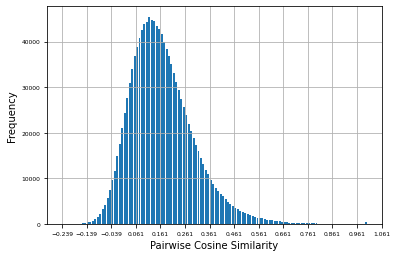

Euclidean Distance Mean: 18.577131181721697
Euclidean Distance Median: 18.652328203619383
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 27.26314477990909


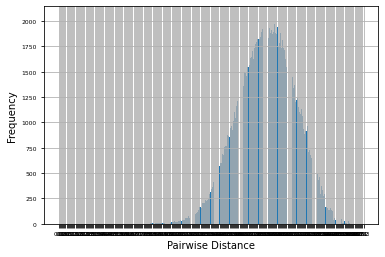

In [9]:
para_vectors = para_vectors.tolist()

para_pairs = [[a, b] for idx, a in enumerate(para_vectors) for b in para_vectors[idx + 1:]]

para_sim_list, para_count, para_dist_list = calculate_pairwise_metrics(para_pairs)
print_similarity_statistics(para_sim_list)
print('\nNumber of Pairs:', len(para_pairs))
print('Number of Orthogonal Pairs:', para_count)
plot_similarities(para_sim_list)

print_distance_statistics(para_dist_list)
plot_distances(para_dist_list)

Cosine Similarity Mean: 0.1691573597750203
Cosine Similarity Median: 0.15236149200855884
Cosine Similarity Mode: 1.0
Cosine Similarity Min: -0.23530321906024274
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 598965
Number of Orthogonal Pairs: 16837
Percentage of Orthogonal Pairs: 0.02811015668695166


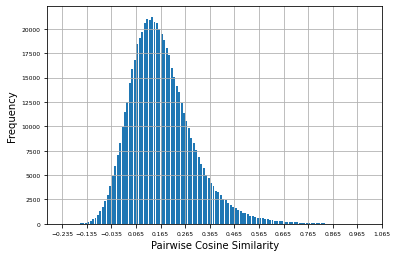

Euclidean Distance Mean: 18.875349759666097
Euclidean Distance Median: 18.996347862671172
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 26.658429844034426


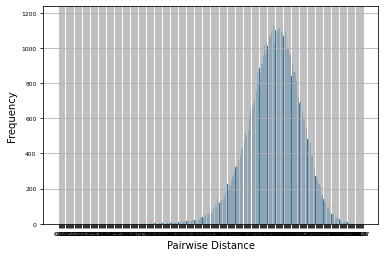

In [10]:
assess_vectors = assess_vectors.tolist()

# for index in range(0, len(assess_vectors)):
#    assess_vectors[index] = assess_vectors[index] / norm(assess_vectors[index])

assess_pairs = [[a, b] for idx, a in enumerate(assess_vectors) for b in assess_vectors[idx + 1:]]

assess_sim_list, assess_count, assess_dist_list = calculate_pairwise_metrics(assess_pairs)
print_similarity_statistics(assess_sim_list)
print('\nNumber of Pairs:', len(assess_pairs))
print('Number of Orthogonal Pairs:', assess_count)
print('Percentage of Orthogonal Pairs:', assess_count/len(assess_pairs))
plot_similarities(assess_sim_list)

print_distance_statistics(assess_dist_list)
plot_distances(assess_dist_list)

In [35]:
km = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
cluster_assignment = km.fit(assess_vectors).labels_
s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
print(s)

0.11807707379786925


In [36]:
clusterIndex_to_clusteredText1 = defaultdict(lambda: " ")
text_id1_to_clusterIndex = dict()

for i, clusterIndex in enumerate(cluster_assignment): # len(cluster_assignment) is equal to len(vectors)
    clusterIndex_to_clusteredText1[clusterIndex] += orig_assess[i] + ". " 
    text_id1_to_clusterIndex[assess_ids[i]] = clusterIndex

Cosine Similarity Mean: 0.16665125599963826
Cosine Similarity Median: 0.15146055856508664
Cosine Similarity Mode: 0.17587893765176843
Cosine Similarity Min: -0.23530321906024274
Cosine Similarity Max: 0.9305980163898293

Number of Pairs: 595186
Number of Orthogonal Pairs: 16835
Percentage of Orthogonal Pairs: 0.02828527552731415


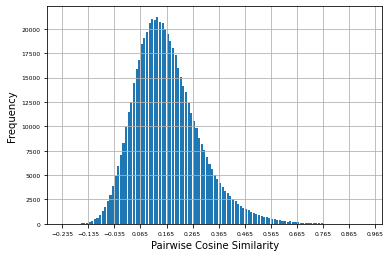

Euclidean Distance Mean: 18.91252767066936
Euclidean Distance Median: 19.012285725391795
Euclidean Distance Mode: 18.751713446573206
Euclidean Distance Min: 4.926834142868749
Euclidean Distance Max: 26.658429844034426


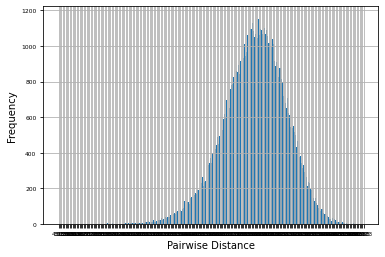

In [37]:
assess_pair_ids = [[a, b] for idx, a in enumerate(assess_ids) for b in assess_ids[idx + 1:]]

inter_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster != b_cluster:
        inter_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(inter_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(inter_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(inter_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)

Cosine Similarity Mean: 0.5638643938196207
Cosine Similarity Median: 0.5817362934581087
Cosine Similarity Mode: 1.0
Cosine Similarity Min: -0.07037965753920675
Cosine Similarity Max: 1.0000000000000002

Number of Pairs: 3779
Number of Orthogonal Pairs: 2
Percentage of Orthogonal Pairs: 0.0005292405398253506


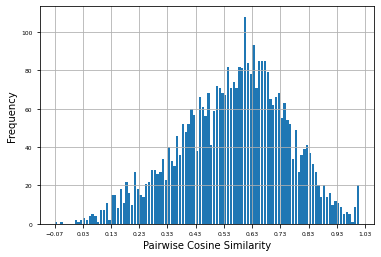

Euclidean Distance Mean: 13.019892723839963
Euclidean Distance Median: 13.1438988214855
Euclidean Distance Mode: 0.0
Euclidean Distance Min: 0.0
Euclidean Distance Max: 22.848896371630378


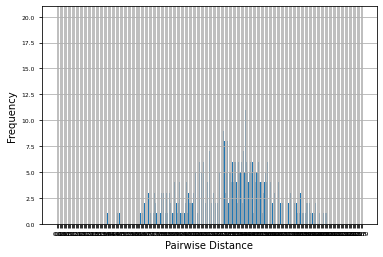

In [38]:
intra_cluster_pairs = []
for index in range(0,len(assess_pairs)):
    a, b = assess_pairs[index]
    a_id, b_id = assess_pair_ids[index]
    a_cluster = text_id1_to_clusterIndex[a_id]
    b_cluster = text_id1_to_clusterIndex[b_id]
    if a_cluster == b_cluster:
        intra_cluster_pairs.append([a,b])
    
cluster_sim_list, cluster_count, cluster_dist_list = calculate_pairwise_metrics(intra_cluster_pairs)
print_similarity_statistics(cluster_sim_list)
print('\nNumber of Pairs:', len(intra_cluster_pairs))
print('Number of Orthogonal Pairs:', cluster_count)
print('Percentage of Orthogonal Pairs:', cluster_count/len(intra_cluster_pairs))
plot_similarities(cluster_sim_list)

print_distance_statistics(cluster_dist_list)
plot_distances(cluster_dist_list)

In [39]:
Counter(cluster_assignment)

Counter({51: 10,
         53: 17,
         28: 4,
         10: 8,
         98: 4,
         92: 7,
         197: 2,
         194: 1,
         87: 15,
         46: 10,
         71: 2,
         163: 2,
         141: 5,
         5: 4,
         140: 4,
         20: 13,
         116: 8,
         113: 3,
         192: 2,
         114: 5,
         27: 10,
         159: 3,
         104: 14,
         126: 3,
         105: 4,
         85: 3,
         57: 10,
         166: 1,
         160: 1,
         193: 10,
         94: 5,
         129: 2,
         11: 4,
         74: 8,
         156: 4,
         168: 2,
         25: 8,
         49: 11,
         29: 4,
         170: 2,
         62: 8,
         95: 4,
         79: 4,
         125: 3,
         153: 7,
         99: 6,
         175: 3,
         80: 7,
         17: 12,
         106: 6,
         1: 10,
         43: 5,
         2: 2,
         123: 4,
         54: 6,
         55: 4,
         187: 4,
         45: 10,
         33: 7,
         130: 5,
   

In [17]:
k = 2
k_list = []
best_k = 75

score_list = []
best_score = -2.0

while k <= 500:
    km = KMeans(n_clusters = k, max_iter = 50000, init = 'k-means++', random_state=43)
    cluster_assignment = km.fit(assess_vectors).labels_
    s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
    if s > best_score:
        best_score = s
        best_k = k
    k_list.append(k)
    score_list.append(s)
    k += 1

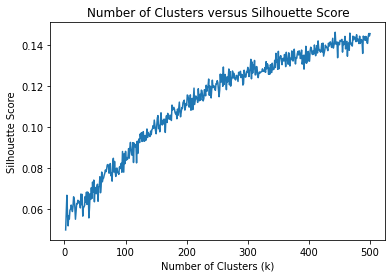

In [18]:
plt.plot(k_list,score_list)
plt.title('Number of Clusters versus Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
print('Best value for k:', best_k)
print('Best Silhouette Score:', best_score)

Best value for k: 443
Best Silhouette Score: 0.14608092016448365


In [40]:
for index in range(0, len(assess_vectors)):
        assess_vectors[index] = assess_vectors[index] / norm(assess_vectors[index])

k = 2
k_list = []
best_k = 75

score_list = []
best_score = -2.0

while k <= 500:
    km = KMeans(n_clusters = k, max_iter = 50000, init = 'k-means++', random_state=43)
    cluster_assignment = km.fit(assess_vectors).labels_
    s = silhouette_score(assess_vectors, cluster_assignment, metric='euclidean')
    if s > best_score:
        best_score = s
        best_k = k
    k_list.append(k)
    score_list.append(s)
    k += 1

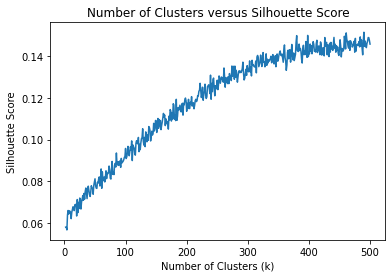

In [41]:
plt.plot(k_list,score_list)
plt.title('Number of Clusters versus Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [42]:
print('Best value for k:', best_k)
print('Best Silhouette Score:', best_score)

Best value for k: 490
Best Silhouette Score: 0.15131349851623313


In [43]:
runs = 0
assignment_list = []
while runs < 10:
    km = KMeans(n_clusters = 200, max_iter = 50000, init = 'k-means++')
    cluster_assignment = km.fit(assess_vectors).labels_
    runs  += 1
    assignment_list.append(cluster_assignment)

clustering_pairs = [[a, b] for idx, a in enumerate(assignment_list) for b in assignment_list[idx + 1:]]

pair_numbers = []
for number in range(0,10):
    for another_number in range(0,10):
        if another_number > number: 
            pair_numbers.append([number+1, another_number+1])

from sklearn.metrics.cluster import adjusted_mutual_info_score

ami_score_list = []
for index in range(0, len(clustering_pairs)):
    label = 'Comparing Run ' + str(pair_numbers[index][0]) + ' and Run ' + str(pair_numbers[index][1])
    ami_score = adjusted_mutual_info_score(clustering_pairs[index][0], clustering_pairs[index][1])
    ami_score_list.append([label, ami_score])
    
import csv

with open("../../../OneDrive/SMART/Jesse_2021/StoryBoards/SMART_cluster_assignment_OLI Biology_sentence-BERT.csv","w+") as my_csv:
    newarray = csv.writer(my_csv,delimiter=',')
    newarray.writerows(assignment_list)
    newarray.writerows(ami_score_list)